In [1]:
pip install ~/.local/share/DiFfRG/python/dist/DiFfRG-1.0.0-py3-none-any.whl

Processing /home/franz/.local/share/DiFfRG/python/dist/DiFfRG-1.0.0-py3-none-any.whl
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached jupyter_bokeh-4.0.5-py3-none-any.whl.metadata (7.1 kB)
  Using cached sortedcollections-2.1.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached cloudpickle-3.1.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached ipywidgets-8.1.7-py3-none-any.whl.metadata (2.4 kB)
  Using cached colorcet-3.1.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached PyYAML-6.0.2-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached xyzservices-2025.4.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached MarkupSafe-3.0.2-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.0 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tz

In [1]:
import DiFfRG.file_io as io
import DiFfRG.plot as plt

import numpy as np
import math

from scipy.interpolate import make_interp_spline
from scipy.optimize import minimize

folder = "./build/"

p_resc =  1.0
Z_resc =  235117399.28975722


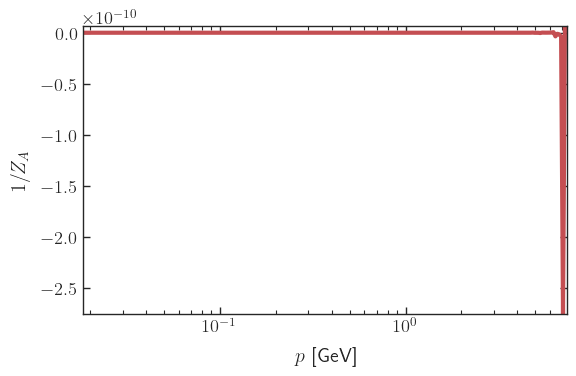

In [3]:
kGeV, Zdat = io.read_k_csv(folder + "Zs.csv")
pGeV = Zdat[0]["pGeV"].to_numpy()
ZA = Zdat[0]["ZA"].to_numpy()

ZA_spl = make_interp_spline(pGeV, ZA, k=2)
better_p = np.exp(np.linspace(-4, 2, 256))
better_ZA = ZA_spl(better_p)

def chi_sq(opt):
    p_resc = opt[0]
    Z_resc = opt[1]
    p_max_lat = 0.955
    # find the maximum of the interpolated data
    p_max = better_p[np.argmin(better_ZA)] * p_resc

    return (p_max - p_max_lat)**2  + (better_ZA[np.argmin(better_ZA)] / Z_resc - 1/2.1)**2

p_resc, Z_resc = minimize(chi_sq, np.array([1, 0.7])).x

print("p_resc = ", p_resc)
print("Z_resc = ", Z_resc)
    
plt.plot_1D(
    [
        {
            "x": better_p*p_resc,
            "y": 1 / better_ZA * Z_resc,
            "scatter": False,
            "color" : plt.palette1[3],
            "label": "this work",
            "lw": 3
        },
    ],
    log_x=True,
    #xlim = [1e-1, 10],
    #ylim = [0, 3],
    legend_loc="upper left",
    xlabel=r"$p$ [GeV]",
    ylabel=r"$1/Z_A$",
    #file="YM_ZA_compare.pdf",
)

maximum at p =  0.2501310038754844
kappa =  0.5691332108519368


/tmp/ipykernel_369675/3368308034.py:20: RuntimeWarning: overflow encountered in power
  return A * p**(4 * kappa)


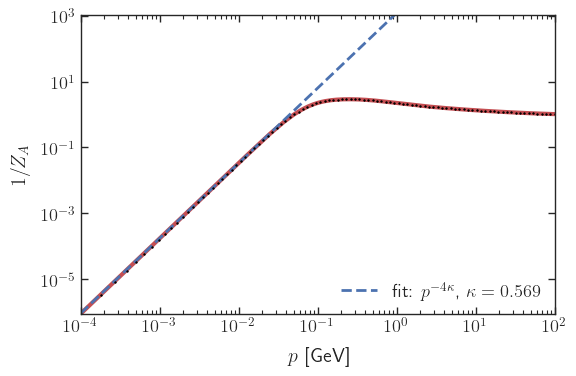

kappa =  0.5727638533311591


/tmp/ipykernel_369675/3368308034.py:65: RuntimeWarning: overflow encountered in power
  return A * p**(2 * kappa)


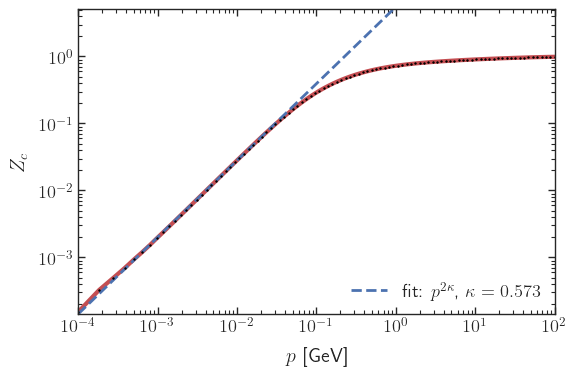

In [242]:
kGeV, Zdat = io.read_k_csv(folder + "Zs.csv")

pGeV = Zdat[0]["pGeV"].to_numpy()
ZA = Zdat[0]["ZA"].to_numpy()
Zc = Zdat[0]["Zc"].to_numpy()

pGeV = pGeV * p_resc

# find the value of p where ZA is smallest, using a spline interpolation
spl = make_interp_spline(pGeV, ZA, k=3)
better_p = np.linspace(pGeV.min(), pGeV.max(), 8000)
better_ZA = spl(better_p)
pMax = better_p[np.argmin(better_ZA)]
print("maximum at p = ", pMax)

# fit ZA with p^(-4 * kappa) using scipy curve_fit
from scipy.optimize import curve_fit

def fit_func(p, kappa, A):
    return A * p**(4 * kappa)

fit_max = 0.02

ZA_fit = 1 / ZA[pGeV < fit_max]
pGeV_fit = pGeV[pGeV < fit_max]
popt, pcov = curve_fit(fit_func, pGeV_fit, ZA_fit)
print("kappa = ", popt[0])

plt.plot_1D(
    [
        {
            "x": better_p,
            "y": 1 / better_ZA,
            "lw": 3,
            "color" : plt.palette1[3],
        },
        {
            "x": pGeV,
            "y": 1 / ZA,
            "scatter": True,
            "color" : "black",
            "size": 2,
        },
        # fit
        {
            "x": pGeV[pGeV < 1],
            "y": fit_func(pGeV[pGeV < 1], *popt),
            "label" : r"fit: $p^{-4 \kappa}$, " + rf"$\kappa = {popt[0]:.3f}$",
            "linestyle": "--",
            "color": plt.palette1[0],
        },
    ],
    log_x=True,
    log_y=True,
    grid=False,
    xlabel=r"$p$ [GeV]",
    ylabel=r"$1/Z_A$",
    #ylim=[np.min(1 / ZA) * 0.99, 8.5],
    #xlim=[1e-4, 40],
    legend_loc="lower right",
    #file="YM_ZA.pdf"
)

def fit_func(p, kappa, A):
    return A * p**(2 * kappa)

Zc_fit = Zc[pGeV < fit_max]
pGeV_fit = pGeV[pGeV < fit_max]
popt, pcov = curve_fit(fit_func, pGeV_fit, Zc_fit)
print("kappa = ", popt[0])

plt.plot_1D(
    [
        {
            "x": pGeV,
            "y": Zc,
            #"label" : r"$Z_c$",
            "lw": 3,
            "color": plt.palette1[3],
        },
        {
            "x": pGeV,
            "y": Zc,
            "scatter": True,
            "color" : "black",
            "size": 2,
        },
        # fit
        {
            "x": pGeV[pGeV < 1],
            "y": fit_func(pGeV[pGeV < 1], *popt),
            "label" : r"fit: $p^{2 \kappa}$, " + rf"$\kappa = {popt[0]:.3f}$",
            "linestyle": "--",
            "color": plt.palette1[0],
        },
    ],
    log_x=True,
    log_y=True,
    grid=False,
    #ylim = [np.min(Zc)*0.99, 1.5],
    xlabel=r"$p$ [GeV]",
    ylabel=r"$Z_c$",
    legend_loc="lower right",
    #file="YM_Zc.pdf"
)

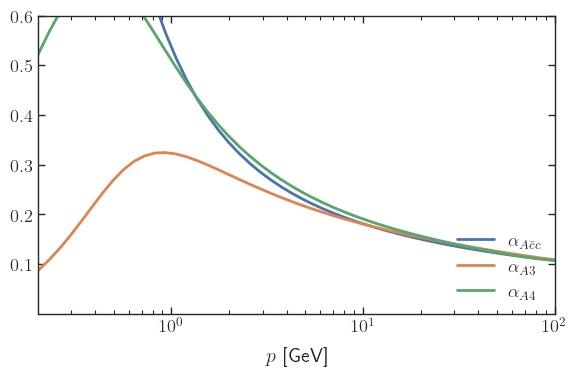

In [243]:
kGeV, alphas = io.read_k_csv(folder + "strong_couplings.csv")
alphaAcbc = alphas[0]["alphaAcbc"].to_numpy()
alphaA3 = alphas[0]["alphaA3"].to_numpy()
alphaA4 = alphas[0]["alphaA4"].to_numpy()

plt.plot_1D(
    [   
        {
            "x": pGeV,
            "y": alphaAcbc,
            "label" : r"$\alpha_{A\bar{c}c}$",
            "lw": 2,
        },
        {
            "x": pGeV,
            "y": alphaA3,
            "label" : r"$\alpha_{A3}$",
            "lw": 2,
        },
        {
            "x": pGeV,
            "y": alphaA4,
            "label" : r"$\alpha_{A4}$",
            "lw": 2,
        },
    ],
    log_x=True,
    #log_y=True,
    grid=False,
    ylim=[1e-5, 0.6],
    xlim=[2.01e-1, 100],
    #ylim=[1e-4, 10],
    xlabel=r"$p$ [GeV]",
    legend_loc="lower right",
    #file="YM_alphas.pdf"
)

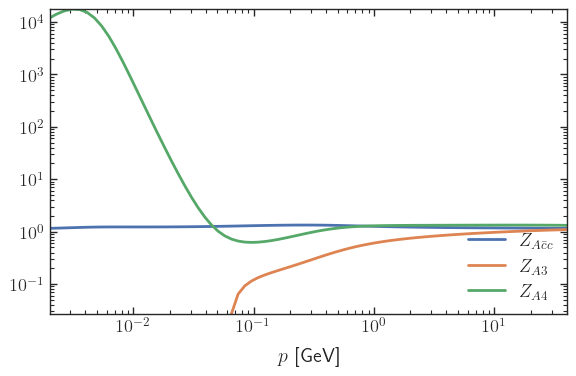

In [123]:
kGeV, alphas = io.read_k_csv(folder + "strong_couplings.csv")
ZAcbc = alphas[0]["ZAcbc"].to_numpy()
ZA3 = alphas[0]["ZA3"].to_numpy()
ZA4 = alphas[0]["ZA4"].to_numpy()

plt.plot_1D(
    [   
        {
            "x": pGeV,
            "y": ZAcbc,
            "label" : r"$Z_{A\bar{c}c}$",
            "lw": 2,
        },
        {
            "x": pGeV,
            "y": ZA3,
            "label" : r"$Z_{A3}$",
            "lw": 2,
        },
        {
            "x": pGeV,
            "y": ZA4,
            "label" : r"$Z_{A4}$",
            "lw": 2,
        },
    ],
    log_x=True,
    log_y=True,
    grid=False,
    #ylim=[1e-5, 10],
    xlim=[2.01e-3, 40],
    xlabel=r"$p$ [GeV]",
    legend_loc="lower right",
    #file="YM_alphas.pdf"
)